In [115]:
from torchvision.models import resnet152

In [116]:
! mkdir API
! mkdir ~/.kaggle

A subdirectory or file API already exists.
The syntax of the command is incorrect.


In [3]:
! pip install torchvision  --index-url https://download.pytorch.org/whl/cu121

^C


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 5.7/5.7 MB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 15.8/15.8 MB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 10.4 MB/s eta 0:00:00


You should consider upgrading via the 'D:\CN341\Basemodel\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [118]:
! cp ./API/kaggle.json  ~/.kaggle

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [119]:
! kaggle datasets download mariaherrerot/idrid-dataset

idrid-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [120]:
! kaggle datasets download nikkich9/derbi-hackathon-retinal-fundus-image-dataset

derbi-hackathon-retinal-fundus-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [121]:
from torch.utils.data import Dataset
import torch
import pandas as pd
import os
from PIL import Image

def load_excel(data_dir, list_file):
    image_names = []
    labels = []
    df_tmp = pd.read_csv(list_file)
    img_num = len(df_tmp)

    for idx in range(img_num):
        image_name = df_tmp["image"][idx]
        label = df_tmp["class"][idx]
        labels.append(label)
        path = os.path.join(data_dir, image_name + '.png')
        if os.path.exists(path):
          image_names.append(path)
          continue
        path = os.path.join(data_dir, image_name + '.jpg')
        if os.path.exists(path):
          image_names.append(path)
          continue
        path = os.path.join(data_dir, image_name + '.jpeg')
        if os.path.exists(path):
          image_names.append(os.path.join(data_dir, image_name + '.jpeg'))
          continue
        else:
          print(f"Image not found for {image_name}")
    print(labels)


    return image_names,labels


class DatasetGenerator(Dataset):
    def __init__(self, data_dir, list_file, transform=None, n_class=6):

        image_names,labels = load_excel(data_dir, list_file)

        self.image_names = image_names
        self.labels = labels
        self.n_class = n_class
        self.transform = transform

    def __getitem__(self, index):
        image_name = self.image_names[index]
        label = self.labels[index]
        image = Image.open(image_name)

        if self.transform is not None:
            image = self.transform(image)
            image  = torch.FloatTensor(image)

        sample = {'image': image, 'class': label}
        return sample


    def __len__(self):
        return len(self.image_names)

In [122]:
import torchvision.models as models
import torch.nn as nn




class ResNet152_DR(nn.Module):
    def __init__(self, n_classes,name):
        super(ResNet152_DR,self).__init__()
        self.n_classes = n_classes
        self.name = name
        self.resnet = models.resnet152() # not use pretained weight
        num_features = self.resnet.fc.out_features
        self.classifier = nn.Sequential(
            nn.Linear(num_features,512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes),
        )



    def forward(self, input):
        x = self.resnet(input)
        output = self.classifier(x)
        return output



In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
import pathlib
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [125]:
idrid = pd.read_csv("/content/idrid_labels.csv")
idrid = idrid[["id_code",	"diagnosis"]]
idrid = idrid.rename(columns={"id_code":"image", "diagnosis":"class"})
base_dir = "/content/idrid/Imagenes"
idrid["path"] = idrid["image"].map(lambda x:os.path.join(base_dir,"{}.jpg".format(x)))
idrid["exist"] = idrid["path"].map(lambda x:os.path.exists(x))

FileNotFoundError: [Errno 2] No such file or directory: '/content/idrid_labels.csv'

In [ ]:
idrid.to_csv("data.csv")

<BarContainer object of 5 artists>

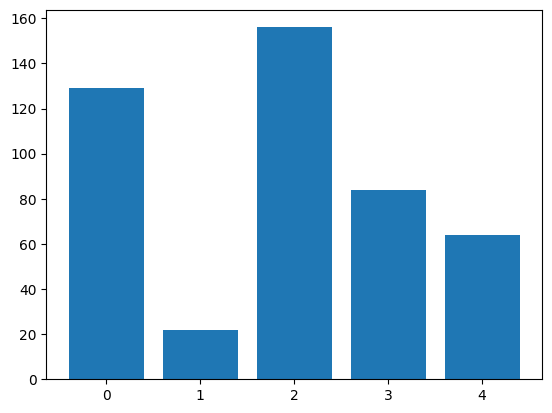

In [ ]:
plt.bar([0,1,2,3,4],idrid['class'].value_counts(sort=False).sort_index())

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize(480),
        transforms.CenterCrop(480),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.01,contrast=0.01,hue=0.01,saturation=0.01),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

In [ ]:
Imagedataset = DatasetGenerator(data_dir="/content/Imagenes/Imagenes", list_file="/content/data.csv",
                             n_class= 5, transform=data_transforms)

[3, 3, 2, 3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 2, 4, 2, 2, 2, 4, 3, 4, 3, 3, 4, 4, 2, 4, 4, 4, 4, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 4, 4, 3, 2, 3, 2, 2, 2, 2, 4, 2, 2, 3, 3, 4, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 2, 1, 2, 4, 2, 2, 2, 2, 4, 2, 3, 4, 4, 2, 2, 2, 2, 3, 4, 2, 4, 4, 4, 3, 2, 2, 4, 1, 2, 2, 3, 2, 4, 3, 2, 3, 3, 2, 2, 0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 2, 2, 2, 2, 4, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 4, 4, 2, 2, 0, 0, 2, 4, 2, 2, 0, 0, 0, 2, 3, 4, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 0, 0, 0, 4, 1, 2, 2, 1, 2, 2, 4, 4, 0, 0, 4, 0, 1, 0, 2, 2, 0, 3, 0, 0, 4, 2, 1, 1, 2, 1, 0, 3, 0, 3, 3, 2, 1, 0, 4, 3, 0, 0, 0, 0, 2, 3, 3, 2, 3, 4, 2, 2, 3, 2, 3, 3, 0, 2, 2, 3, 0, 2, 2, 3, 2, 3, 0, 2, 3, 0, 3, 2, 2, 2, 0, 3, 3, 3, 0, 2, 4, 4, 2, 3, 0, 3, 0, 3, 

In [ ]:
Imagedataset[0]

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [ ]:
def test_model(model, dataloaders, device):
  print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
  model = model.eval()

  with torch.no_grad():
    for batch in tqdm(dataloaders):
      inputs = batch["image"].to(device)
      #labels = labels.to(device)
      outputs = model(inputs)
      print(outputs)


In [ ]:
from torch.optim import lr_scheduler
import torch.optim as optim

In [ ]:
def train_epoch(model,dataloaders,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  i = 1
  for batch in tqdm(dataloaders):
    inputs = batch["image"].to(device)
    labels = batch["class"].to(device)
    print(labels)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()

  return model, correct_predictions.double() / n_examples ,np.mean(losses) #
def checkpoint_path(filename,model_name):

  checkpoint_folderpath = pathlib.Path(f'checkpoint/{model_name}')
  print(checkpoint_folderpath)
  checkpoint_folderpath.mkdir(exist_ok=True,parents=True)
  return checkpoint_folderpath/filename

def train_model(model, dataloaders,  dataset_sizes, device, n_epochs=5): # train ต่อจาก epoch ที่18
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.4)
    loss_fn = nn.CrossEntropyLoss(reduction='mean').to(device)
    best_model_path = checkpoint_path('best_model_state.ckpt',model.name)

    #print(model)

    #best_accuracy = 0
    for epoch in range(1,n_epochs+1):
      print(f'Epoch {epoch }/{n_epochs}')
      print('-' * 10)
      model, train_acc, train_loss = train_epoch(model,dataloaders,loss_fn,optimizer,device,scheduler,n_examples=dataset_sizes)
      print(f'Train loss {train_loss} accuracy {train_acc}')
      #val_acc, val_loss = eval_model(model,dataloaders['val_FGR'],loss_fn,device,dataset_sizes['val_FGR'])
      #print(f'validation   loss {val_loss} accuracy {val_acc}')


      torch.save(model.state_dict(), checkpoint_path('best_model_state_'+str(epoch)+'.ckpt',model.name))
      # เก็บ weight ที่ดีสุด ใช้ val เเทน test
      #if val_acc> best_accuracy:
      #  torch.save(model.state_dict(), best_model_path)
      # best_accuracy = val_acc
    #print(f'Best val accuracy: {best_accuracy}')
    #model.load_state_dict(torch.load(best_model_path))
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders= torch.utils.data.DataLoader(Imagedataset, batch_size=4,shuffle=True, num_workers=2)
#dataloaders= {x: torch.utils.data.DataLoader(dataloaders[x], batch_size=3, shuffle=True
#                                               , num_workers=2)
#                for x in  ['train','val']}

In [ ]:
model = ResNet152_DR(5,"resnet152_train")

In [ ]:
len(Imagedataset)

455

In [ ]:
train_model(model,dataloaders,len(Imagedataset), device, n_epochs=25)

checkpoint/resnet152_train
Epoch 1/25
----------


  0%|          | 0/114 [00:00<?, ?it/s]

tensor([3, 2, 3, 1])


  1%|          | 1/114 [00:11<22:07, 11.75s/it]

tensor([3, 4, 0, 2])


  2%|▏         | 2/114 [00:18<16:19,  8.75s/it]

tensor([2, 3, 4, 2])


  3%|▎         | 3/114 [00:25<14:51,  8.03s/it]

tensor([2, 0, 0, 0])


  4%|▎         | 4/114 [00:31<13:30,  7.37s/it]

tensor([2, 3, 3, 0])


  4%|▍         | 5/114 [00:38<13:07,  7.23s/it]

tensor([0, 2, 2, 2])


  5%|▌         | 6/114 [00:45<12:22,  6.87s/it]

tensor([3, 2, 0, 0])


  6%|▌         | 7/114 [00:51<12:07,  6.80s/it]

tensor([2, 2, 2, 4])


  7%|▋         | 8/114 [00:58<12:13,  6.92s/it]

tensor([2, 0, 0, 0])


  8%|▊         | 9/114 [01:05<11:44,  6.71s/it]

tensor([2, 0, 0, 4])


  9%|▉         | 10/114 [01:12<11:47,  6.81s/it]

tensor([3, 2, 2, 4])


 10%|▉         | 11/114 [01:18<11:29,  6.70s/it]

tensor([2, 2, 3, 2])


 11%|█         | 12/114 [01:25<11:26,  6.73s/it]

tensor([2, 2, 2, 4])


 11%|█▏        | 13/114 [01:31<11:02,  6.56s/it]

tensor([3, 0, 2, 0])


 12%|█▏        | 14/114 [01:38<10:52,  6.52s/it]

tensor([2, 4, 3, 2])


 13%|█▎        | 15/114 [01:44<10:48,  6.55s/it]

tensor([4, 4, 4, 0])


 14%|█▍        | 16/114 [01:50<10:31,  6.45s/it]

tensor([2, 2, 2, 0])


 15%|█▍        | 17/114 [01:57<10:35,  6.55s/it]

tensor([1, 0, 0, 3])


 16%|█▌        | 18/114 [02:03<10:20,  6.46s/it]

tensor([2, 3, 2, 1])


 17%|█▋        | 19/114 [02:10<10:23,  6.57s/it]

tensor([1, 0, 3, 2])


 18%|█▊        | 20/114 [02:16<10:07,  6.46s/it]

tensor([0, 4, 3, 1])


 18%|█▊        | 21/114 [02:23<10:07,  6.53s/it]

tensor([0, 2, 2, 3])


 19%|█▉        | 22/114 [02:29<09:52,  6.44s/it]

tensor([2, 0, 2, 2])


 20%|██        | 23/114 [02:36<09:48,  6.46s/it]

tensor([2, 4, 0, 0])


 21%|██        | 24/114 [02:43<09:50,  6.56s/it]

tensor([2, 2, 0, 2])


 22%|██▏       | 25/114 [02:49<09:34,  6.46s/it]

tensor([0, 4, 0, 0])


 23%|██▎       | 26/114 [02:56<09:40,  6.60s/it]

tensor([3, 0, 0, 2])


In [ ]:
len([114, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 163, 166, 167, 168, 170, 171, 172, 173, 174, 175, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 205, 206, 207, 210, 215, 216, 221, 222, 223, 227, 228, 229, 230, 231, 235, 236, 237, 238, 239, 241, 244, 245, 246, 247, 257, 258, 260, 262, 265, 267, 268, 275, 277, 282, 285, 286, 287, 288, 301, 305, 311, 314, 319, 323, 329, 331, 334, 341, 344, 348, 349, 355, 357, 360, 361, 367, 401, 402, 409, 410, 413, 418, 420, 425, 430, 431, 436, 438, 448, 450, 454])

129

In [ ]:
df = pd.DataFrame(columns=["image","class"])

In [ ]:
df.loc[1,'image'] = "test"
df.loc[1,'class'] = 0

In [ ]:
df

,image,class


In [ ]:
import os 
i = 0
for p in os.listdir("D:\CN341\CNN_Basemodel\Resnetmodel/augment"):
    df.loc[i,'image'] = p[:-5]
    df.loc[i,'class'] = int(p.split("_")[2])
    i += 1

In [ ]:
df

,image,class
0,aug_image_0_114_0,0
1,aug_image_0_135_0,0
2,aug_image_0_143_0,0
3,aug_image_0_153_0,0
4,aug_image_0_166_0,0
...,...,...
130,aug_image_4_87_0,4
131,aug_image_4_93_0,4
132,aug_image_4_95_0,4
133,aug_image_4_97_0,4


In [ ]:
df = pd.read_csv("D:\CN341\CNN_Basemodel\Resnetmodel/augmented.csv")

In [ ]:
data = pd.read_csv("D:\CN341\CNN_Basemodel\Resnetmodel\idrid-dataset\data.csv")

In [ ]:
df = df[["image","class"]]

In [ ]:
data = data[["image","class"]]

In [ ]:
data

,image,class
0,IDRiD_001,3
1,IDRiD_002,3
2,IDRiD_003,2
3,IDRiD_004,3
4,IDRiD_005,4
...,...,...
450,IDRiD_096test,0
451,IDRiD_100test,2
452,IDRiD_101test,1
453,IDRiD_102test,2


In [ ]:
df

,image,class
0,aug_image_0_257_0,0
1,aug_image_0_135_0,0
2,aug_image_0_178_0,0
3,aug_image_0_170_0,0
4,aug_image_0_288_0,0
...,...,...
320,aug_image_4_375_1,4
321,aug_image_4_419_0,4
322,aug_image_4_351_0,4
323,aug_image_4_376_5,4


,image,class
0,IDRiD_001,3
1,IDRiD_002,3
2,IDRiD_003,2
3,IDRiD_004,3
4,IDRiD_005,4
...,...,...
775,aug_image_4_375_1,4
776,aug_image_4_419_0,4
777,aug_image_4_351_0,4
778,aug_image_4_376_5,4


In [8]:
DRFID = pd.read_csv("D:\CN341\CNN_Basemodel\Resnetmodel/train.csv")

In [9]:
DRFID

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
3430,315991e4e5d3.jpg,0,0,0,0,0,0,1
3431,46ff848f59d4.jpg,0,0,0,0,0,0,1
3432,2477323c9434.jpg,0,0,0,0,0,0,1
3433,0a1ca36be2c5.jpg,0,0,0,0,0,0,1


In [10]:
DRFID  = DRFID.loc[DRFID["diabetic retinopathy"] ==0].reset_index(drop=True)
DRFID  = DRFID[["filename","normal"]]
DRFID =  DRFID.rename(columns={"filename":"image","normal":"level"})
DRFID["image"] = DRFID["image"].map(lambda x: x[:-4])
DRFID["class"] = DRFID["level"].replace(0,5)

In [11]:
DRFID = DRFID[["image","class"]]

In [29]:
DRFID["image"]

0       c24a1b14d253
1       9ee905a41651
2       3f58d128caf6
3       4ce6599e7b20
4       0def470360e4
            ...     
2675    315991e4e5d3
2676    46ff848f59d4
2677    2477323c9434
2678    0a1ca36be2c5
2679    96f11f20fe93
Name: image, Length: 2680, dtype: object

In [24]:
l = [image[:-4] for image in os.listdir("D:\CN341\CNN_Basemodel\Resnetmodel\DRFID")]

In [31]:
l

['001e39f3c4e7',
 '004f7ec58fad',
 '0056b75f7627',
 '00d20ad58b44',
 '012e91949ec4',
 '01f94a77a3d5',
 '02840e6a14e2',
 '028c20788008',
 '02aa097548d4',
 '0322e171654b',
 '036',
 '037',
 '03a747b6e5ed',
 '03ce7c893a99',
 '041',
 '0417075a2a99',
 '043884e9ec50',
 '04bf0ab5d112',
 '050',
 '05cc3d7f096d',
 '062a60802fd1',
 '066a3f367311',
 '06706ab5002a',
 '069',
 '06a6c5d1a41e',
 '06c3122899e7',
 '06dccb552e83',
 '06f003e92e55',
 '070f4bb26567',
 '072',
 '076',
 '077ad8eccfdb',
 '07ea886656c8',
 '08027a212382',
 '085cff5e3e72',
 '086',
 '087',
 '08fdfdb8bcc3',
 '093',
 '094',
 '0956db52aab3',
 '097',
 '09a58f5d52c4',
 '09adc22b7892',
 '09d81f09c306',
 '0a04f3d123de',
 '0a6dc8e605a7',
 '0aafce02db98',
 '0aecf8f7fca9',
 '0b0c9f0cb813',
 '0b8e598bf529',
 '0cf5112a8c20',
 '0d0cd8e65f07',
 '0d83802e04f5',
 '0da8fec8043d',
 '0dfe41e49882',
 '0eb5e463b2fa',
 '0ede365f87e4',
 '0f44ca2fc36c',
 '0f8d760f8511',
 '0f8d8406ca63',
 '0fc664626c1b',
 '1024_left',
 '1027ef7b4c3a',
 '1028_left',
 '102_lef

In [32]:
index = []
for i,image in enumerate(DRFID["image"]):
    if image in l:
        index.append(i)

In [33]:
len(index)

705

In [ ]:
import random

In [ ]:
random.seed(42)
x= random.sample(index, 156)

In [141]:
x

[1639,
 320,
 55,
 1921,
 722,
 650,
 592,
 372,
 1903,
 290,
 1728,
 1913,
 1454,
 251,
 1531,
 1099,
 74,
 70,
 267,
 577,
 617,
 1353,
 1551,
 57,
 1483,
 518,
 1846,
 1671,
 1813,
 2121,
 1095,
 580,
 1177,
 1530,
 736,
 18,
 1975,
 416,
 1804,
 2114,
 897,
 2083,
 406,
 572,
 1983,
 893,
 2125,
 263,
 994,
 281,
 950,
 901,
 1555,
 700,
 106,
 1877,
 1216,
 1432,
 352,
 989,
 227,
 1473,
 779,
 1616,
 1595,
 953,
 1510,
 502,
 1820,
 196,
 118,
 1692,
 608,
 772,
 228,
 2106,
 289,
 2055,
 2075,
 1209,
 1635,
 958,
 423,
 968,
 939,
 540,
 1711,
 703,
 2094,
 1762,
 1660,
 202,
 1572,
 1982,
 439,
 1426,
 1874,
 2140,
 424,
 1224,
 991,
 710,
 1640,
 1774,
 1478,
 578,
 1766,
 859,
 146,
 609,
 2112,
 845,
 1040,
 707,
 174,
 552,
 1493,
 1848,
 840,
 553,
 1681,
 1339,
 1028,
 1647,
 1215,
 379,
 701,
 2135,
 653,
 2098,
 1434,
 694,
 1520,
 1126,
 1519,
 1037,
 2003,
 1906,
 371,
 1361,
 1325,
 257,
 122,
 318,
 403,
 1615,
 2080,
 1756,
 2078,
 1544,
 164,
 1007,
 998,
 1795,
 

In [142]:
d = DRFID.iloc[x]["image"]

In [143]:
d

1639    40f462633e04
320     2203a1daa336
55      ea4c6453b94c
1921    fa0acaaeb3ff
722     6e9483d3205a
            ...     
1007    5ff117fe5c99
998     536909772204
1795    2401c17651ba
1239    5539b21fa7ea
1406    b0589215a008
Name: image, Length: 156, dtype: object

In [14]:
other = DRFID.iloc[index]

In [18]:
other

,image,class
0,c24a1b14d253,5
1,9ee905a41651,5
12,802b4bfabd52,5
14,7e7e16ee00f4,5
15,012e91949ec4,5
...,...,...
2141,37310c9115b3,5
2148,7e22b6698e47,5
2151,8bf923c04010,5
2152,872b1c04bc2e,5


In [19]:
other['class'].value_counts(sort=False)

5    705
Name: class, dtype: int64

<BarContainer object of 1 artists>

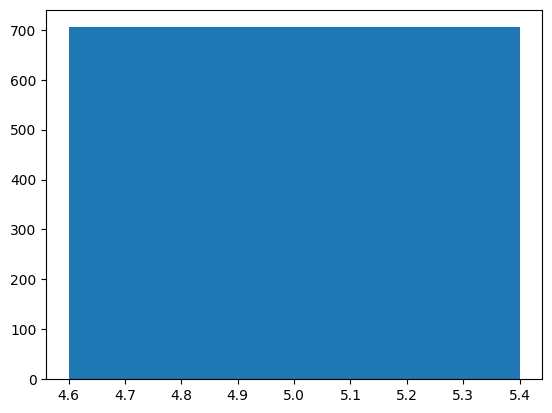

In [20]:
plt.bar([5],other['class'].value_counts(sort=False).sort_index())

In [21]:
other.to_csv("test.csv")

In [146]:
#combine = pd.concat([data, df,other], axis=0, ignore_index=True)

In [139]:
combine = pd.read_csv("D:\CN341\Basemodel\Resnetmodel\idrid-dataset/train.csv")

In [147]:
combine = combine[["image","class"]]

In [148]:
combine['class'].value_counts()

class
5    125
1    125
2    125
0    125
4    124
3    124
Name: count, dtype: int64

In [151]:
combine

,image,class
0,aug_image_4_59_2,4
1,aug_image_4_4_2,4
2,94973b732f82,5
3,aug_image_1_271_1,1
4,IDRiD_246,4
...,...,...
743,aug_image_4_14_0,4
744,IDRiD_403,1
745,aug_image_4_377_1,4
746,IDRiD_117,2


In [155]:
i = combine.loc[combine["class"]==5].index

In [156]:
i

Index([  2,   9,  11,  23,  33,  42,  43,  45,  59,  61,
       ...
       690, 691, 695, 712, 727, 733, 737, 740, 741, 747],
      dtype='int64', length=125)

In [159]:
combine =combine.drop(i).reset_index(drop=True)

In [160]:
combine

,index,image,class
0,0,aug_image_4_59_2,4
1,1,aug_image_4_4_2,4
2,3,aug_image_1_271_1,1
3,4,IDRiD_246,4
4,5,IDRiD_122,2
...,...,...,...
618,742,IDRiD_343,2
619,743,aug_image_4_14_0,4
620,744,IDRiD_403,1
621,745,aug_image_4_377_1,4


<BarContainer object of 6 artists>

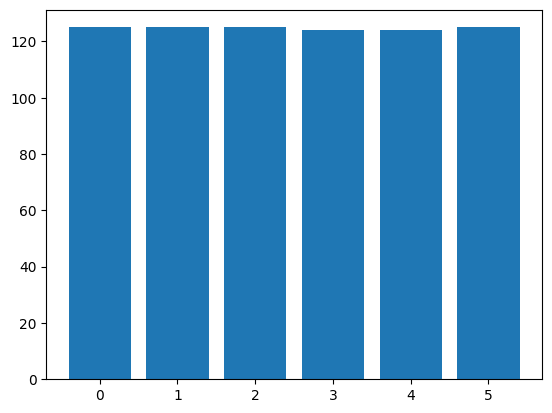

In [158]:
plt.bar([0,1,2,3,4,5],combine['class'].value_counts(sort=False).sort_index())

In [9]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(combine["image"], combine["class"], test_size=0.2, random_state=42,stratify=combine["class"])

In [27]:
train = pd.DataFrame(columns=["image","class"])
val = pd.DataFrame(columns=["image","class"])

In [29]:
val["image"] = X_test
val["class"] = y_test

In [30]:
train["image"] = X_train
train["class"] = y_train

In [35]:
train.to_csv("train.csv")

In [36]:
val.to_csv("val.csv")

<BarContainer object of 6 artists>

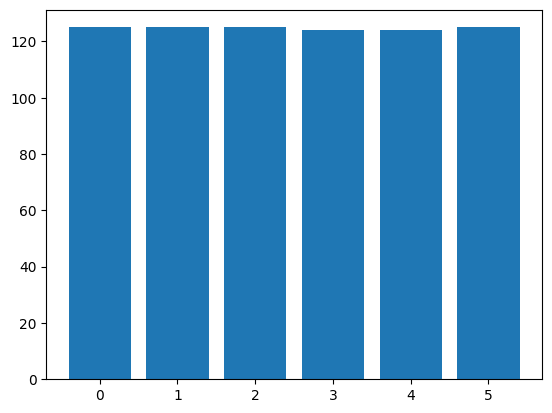

In [33]:
plt.bar([0,1,2,3,4,5],train["class"].value_counts(sort=False).sort_index())

<BarContainer object of 6 artists>

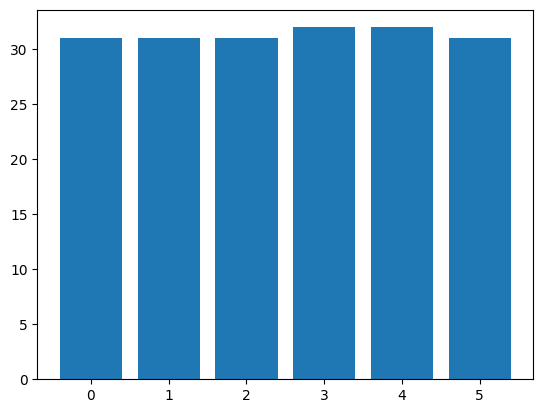

In [34]:
plt.bar([0,1,2,3,4,5],val["class"].value_counts(sort=False).sort_index())

In [ ]:
train_acc =[0.1658,0.2045]

In [1]:
train_acc =[1,2]
val_acc = [3,4]
train_loss = [5,5]
val_loss = [1 ,1]

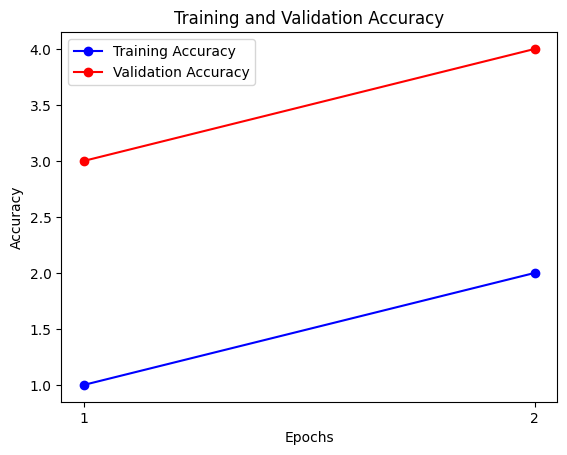

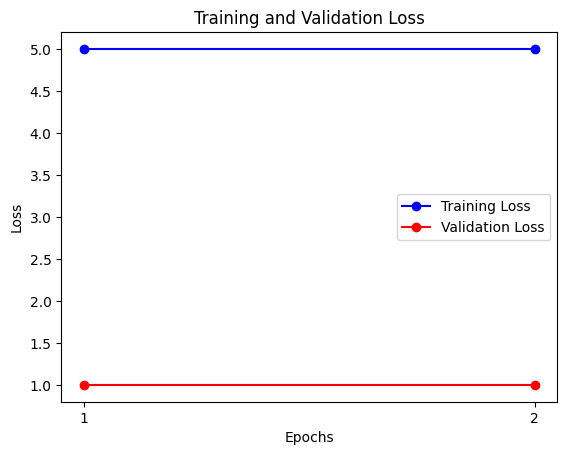

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(train_metrics, val_metrics, metric_name):
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metrics, 'ro-', label=f'Validation {metric_name}')
    plt.xticks(epochs)
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Assuming train_acc, val_acc, train_loss, and val_loss are lists of accuracies and losses for each epoch
plot_metrics(train_acc, val_acc, 'Accuracy')
plot_metrics(train_loss, val_loss, 'Loss')


In [1]:
! kaggle datasets download mariaherrerot/messidor2preprocess


  0%|          | 0.00/381M [00:00<?, ?B/s]
  0%|          | 1.00M/381M [00:01<06:57, 955kB/s]
  1%|          | 2.00M/381M [00:01<03:30, 1.88MB/s]
  1%|          | 3.00M/381M [00:01<02:11, 3.01MB/s]
  1%|▏         | 5.00M/381M [00:01<01:15, 5.21MB/s]
  2%|▏         | 6.00M/381M [00:01<01:04, 6.07MB/s]
  2%|▏         | 8.00M/381M [00:01<00:53, 7.33MB/s]
  3%|▎         | 10.0M/381M [00:02<00:45, 8.47MB/s]
  3%|▎         | 12.0M/381M [00:02<00:40, 9.63MB/s]
  4%|▎         | 14.0M/381M [00:02<00:39, 9.69MB/s]
  4%|▍         | 16.0M/381M [00:02<00:39, 9.74MB/s]
  4%|▍         | 17.0M/381M [00:02<00:41, 9.11MB/s]
  5%|▍         | 18.0M/381M [00:02<00:41, 9.25MB/s]
  5%|▍         | 19.0M/381M [00:03<00:41, 9.21MB/s]
  6%|▌         | 21.0M/381M [00:03<00:39, 9.60MB/s]
  6%|▌         | 23.0M/381M [00:03<00:37, 10.1MB/s]
  7%|▋         | 25.0M/381M [00:03<00:36, 10.1MB/s]
  7%|▋         | 26.0M/381M [00:03<00:38, 9.77MB/s]
  7%|▋         | 28.0M/381M [00:03<00:35, 10.4MB/s]
  8%|▊         | 30.0

In [2]:
import torch

In [8]:
outputs = torch.tensor([[ 5.6170, -5.7601, -3.2077, -5.8449, -3.2135,  9.6469]]
       )

In [10]:
x,y = torch.max(outputs, dim=1)

In [12]:
y.data.cpu().numpy()[0]

5

In [24]:
messidor_df = pd.read_csv("D:\CN341\CNN_Basemodel\Resnetmodel\messidor2preprocess\messidor_data.csv")

In [25]:
messidor_df  = messidor_df[["id_code","diagnosis"]]

In [26]:
messidor_df["id_code"] = messidor_df["id_code"].map(lambda x: x[:-4])

In [27]:

messidor_df = messidor_df.rename(columns={"id_code":"image","diagnosis":"class"})

<BarContainer object of 5 artists>

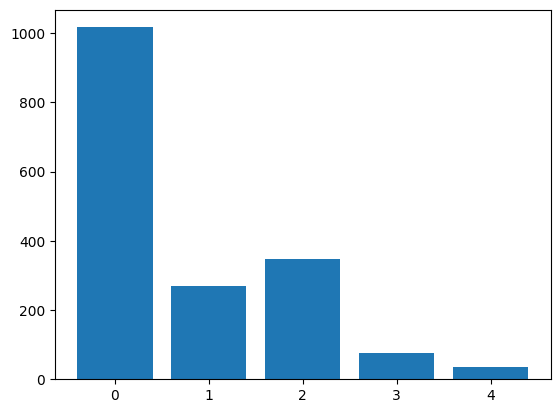

In [28]:

plt.bar([0,1,2,3,4],messidor_df  ['class'].value_counts(sort=False).sort_index())

In [27]:
messidor_df.to_csv("test_messi.csv")

In [20]:
train_accuracy_each_epoch = torch.tensor(0.2567, device='cuda:0', dtype=torch.float64)

In [21]:
train_accuracy_each_epoch.item()

0.2567

In [15]:
train_accuracy_each_epoch.data[0].cpu()

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [34]:
df = pd.read_csv("D:\CN341\CNN_Basemodel\Resnetmodel\idrid-dataset/val.csv")

In [35]:
df["class"].value_counts()

class
4    32
3    32
2    31
0    31
5    31
1    31
Name: count, dtype: int64

In [8]:
import torch
print(torch.__version__)

In [ ]:
torch.cuda.is_available()

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd

In [7]:
ytrue  = pd.read_csv("D:\CN341\Basemodel\Resnetmodel\idrid-dataset/test_messi.csv")

In [8]:
ytrue

,Unnamed: 0,image,class
0,0,20051020_43808_0100_PP,0
1,1,20051020_43832_0100_PP,1
2,2,20051020_43882_0100_PP,1
3,3,20051020_43906_0100_PP,2
4,4,20051020_44261_0100_PP,0
...,...,...,...
1739,1739,IM004806,0
1740,1740,IM004811,1
1741,1741,IM004812,2
1742,1742,IM004831,0


In [9]:
ypre  = pd.read_csv("D:\CN341\Basemodel/result.csv")

In [10]:
ypre

,Unnamed: 0,No,predict
0,1,1,0
1,2,2,4
2,3,3,2
3,4,4,2
4,5,5,0
...,...,...,...
1739,1740,1740,4
1740,1741,1741,4
1741,1742,1742,4
1742,1743,1743,0


In [12]:
confusion_matrix(ytrue["class"], ypre["predict"])

array([[ 87, 102, 121,   9, 649,  49],
       [ 24,  36,  31,   6, 169,   4],
       [  6,  15,  54,  28, 240,   4],
       [  0,   0,   2,   9,  64,   0],
       [  0,   0,   1,   2,  32,   0],
       [  0,   0,   0,   0,   0,   0]], dtype=int64)

In [15]:
accuracy_score(ytrue["class"], ypre["predict"])

0.125

In [130]:
test_transform = transforms.Compose([
      transforms.Resize(400, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(400),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.1, 0.1, 0.1])
    ])

In [112]:
img = cv2.imread("D:\CN341\Basemodel\Resnetmodel\messidor2preprocess\messidor-2\messidor-2\preprocess/20051020_43808_0100_PP.png")

In [131]:
img

array([[[2, 0, 2],
        [1, 0, 1],
        [2, 0, 2],
        ...,
        [2, 0, 2],
        [2, 0, 2],
        [1, 0, 1]],

       [[2, 0, 2],
        [2, 0, 2],
        [2, 0, 2],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]],

       [[1, 0, 1],
        [2, 0, 2],
        [1, 0, 1],
        ...,
        [1, 0, 1],
        [3, 1, 3],
        [3, 1, 3]],

       ...,

       [[1, 0, 1],
        [2, 0, 2],
        [3, 1, 3],
        ...,
        [2, 0, 2],
        [1, 0, 1],
        [2, 0, 2]],

       [[2, 1, 2],
        [2, 0, 2],
        [1, 0, 1],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [2, 0, 2]],

       [[1, 0, 1],
        [2, 0, 2],
        [1, 0, 1],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [2, 0, 2]]], dtype=uint8)

In [114]:
img.shape

(512, 512, 3)

In [132]:
x= Image.open("D:\CN341\Basemodel\Resnetmodel\messidor2preprocess\messidor-2\messidor-2\preprocess/20051020_43808_0100_PP.png")

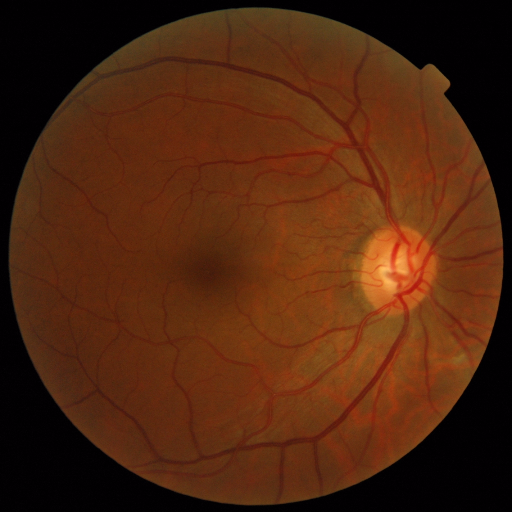

In [133]:
x

In [134]:
y = test_transform(x)

In [135]:
y

tensor([[[-4.7716, -4.8108, -4.7716,  ..., -4.7716, -4.7716, -4.8108],
         [-4.7716, -4.7716, -4.7716,  ..., -4.7716, -4.8108, -4.7716],
         [-4.8108, -4.7716, -4.8108,  ..., -4.7716, -4.8108, -4.7716],
         ...,
         [-4.8108, -4.7716, -4.8108,  ..., -4.8108, -4.8108, -4.8108],
         [-4.7716, -4.7716, -4.8108,  ..., -4.7716, -4.8108, -4.7716],
         [-4.8108, -4.7716, -4.7716,  ..., -4.7716, -4.8108, -4.7716]],

        [[-4.5600, -4.5600, -4.5600,  ..., -4.5208, -4.5600, -4.5600],
         [-4.5600, -4.5600, -4.5600,  ..., -4.5600, -4.5600, -4.5600],
         [-4.5600, -4.5600, -4.5600,  ..., -4.5600, -4.5600, -4.5600],
         ...,
         [-4.5600, -4.5600, -4.5600,  ..., -4.5600, -4.5600, -4.5600],
         [-4.5208, -4.5600, -4.5600,  ..., -4.5600, -4.5600, -4.5600],
         [-4.5600, -4.5600, -4.5600,  ..., -4.5600, -4.5600, -4.5600]],

        [[-3.9816, -4.0208, -3.9816,  ..., -3.9816, -3.9816, -4.0208],
         [-3.9816, -3.9816, -3.9816,  ..., -3

In [136]:
y = np.transpose(y,(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


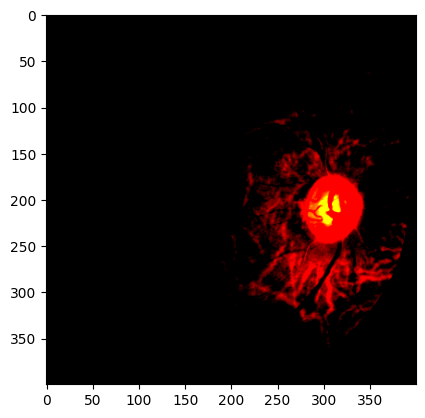

In [137]:
plt.imshow(y)